In [1]:
from legwork import evol, utils
import legwork.strain as strain
import legwork
import pandas as pd
import numpy as np
import numpy.ma as ma
import astropy.units as u
from astropy.visualization import quantity_support
quantity_support()
import matplotlib.pyplot as plt
import scipy.special as sp
from scipy.integrate import solve_ivp
from scipy.interpolate import interp1d
from scipy.optimize import fsolve
from astropy.constants import G
from astropy.constants import c

from scipy.integrate import quad
from scipy.special import gamma
from scipy.special import hyp2f1
from joblib import Parallel, delayed, Memory
from numba import njit
import os
import math
from math import gamma as math_gamma
os.environ["NPY_NUM_BUFSIZE"] = "8192"   # 增大NumPy缓冲区
os.environ["NPY_NUM_THREADS"] = "1"      # 禁用NumPy内部多线程
os.environ["MKL_NUM_THREADS"] = "1"      # 禁用MKL多线程


## Initial Condition

In [ ]:
m_1 = 10 * u.Msun
m_2 =  4.3*10**6 * u.Msun
mu = m_1 * m_2 / (m_1 + m_2)
M = m_1 + m_2
m_c = utils.chirp_mass(m_1, m_2)

ecc_i = 0.9997
a_i = 0.01 * u.pc
f_orb_i = utils.get_f_orb_from_a(a =a_i, m_1=m_1, m_2=m_2)

dist = 8 * u.kpc
t_obs = 1 * u.yr

beta = utils.beta(m_1=m_1, m_2=m_2)
c_0 = utils.c_0(a_i, ecc_i)

M_sun = (1 * u.Msun).si.value      
pc = (1 * u.pc).si.value

gam = 2
rs = 0.01 * pc                 
rhos = 1.0823186e8 * M_sun / pc**3 

## Time derivative of a and e

### DM friction

In [ ]:
@njit(nogil=True, fastmath=True)
def f_df(v_dm, v_c, gam):
    
    numerator = math_gamma(gam + 1)
    denominator = math_gamma(gam - 0.5) 
    
    base_factor = numerator / denominator
    pow_factor = (2**gam) * (np.pi**1.5) * v_c**(2 * gam)
    
    velocity_term = 2 * v_c**2 - v_dm**2
    if velocity_term <= 0:
        return 0.0
    
    return (base_factor / pow_factor) * velocity_term**(gam - 1.5)
@njit(nogil=True, fastmath=True)
def rho(gam, r, rs, rhos):
    return rhos * (r / rs)**-gam

def epsilon(a, e, f, gam):
    
    cos_u = (np.cos(f) + e) / (1 + e * np.cos(f))
    r = a * (1 - e * cos_u)
    v = np.sqrt(G.si.value * m_2.si.value * (1 + e * cos_u) / (a * (1 - e * cos_u)))
    v_c = np.sqrt(G.si.value * m_2.si.value / r)
    v_esc = np.sqrt(2) * v_c
    if v >= v_esc:
        return 0.0

    alpha, _ = quad(
        lambda x: 4 * np.pi * f_df(x, v_c, gam) * x**2,
        0, v,
        epsabs=1e-5, epsrel=1e-4
    )
    
    beta, _ = quad(
        lambda x: 4 * np.pi * f_df(x, v_c, gam) * x**2 * np.log((x + v)/(x - v)),
        v, v_esc,
        epsabs=1e-5, epsrel=1e-4
    )
    
    delta, _ = quad(
        lambda x: -8 * np.pi * v * f_df(x, v_c, gam) * x,
        v, v_esc,
        epsabs=1e-5, epsrel=1e-4
    )
    rho_val = rho(gam, r, rs, rhos)
    log_term = np.log(pc * v_c**2 / (G.si.value * m_2.si.value))
    return -4 * np.pi * G.si.value**2 * rho_val * m_1.si.value * (log_term * alpha + beta + delta)

def da_dt_integrand(f, a_elem, e_elem, gam):

    eps = epsilon(a_elem, e_elem, f, gam)
    cos_f = np.cos(f)
    ecos = e_elem * cos_f
    denominator = (1 + ecos)**2 * np.sqrt(1 + e_elem**2 + 2*ecos)
    return eps / denominator
def da_dt_compute_element(a_elem, e_elem):
  
    n = np.sqrt(G.si.value * m_2.si.value / a_elem**3)
    prefactor = (1 - e_elem**2)**2 / (np.pi * n**3 * a_elem**2)
    
    integral, _ = quad(
        da_dt_integrand,
        0, 2*np.pi,
        args=(a_elem, e_elem, gam),
        epsabs=1e-5,
        epsrel=1e-4,
        limit=100
    )
    return prefactor * integral

def de_dt_integrand(f, a_elem, e_elem, gam):

    eps = epsilon(a_elem, e_elem, f, gam)
    cos_f = np.cos(f)
    ecos = e_elem * cos_f
    denominator = (1 + e_elem**2 + 2*ecos)**1.5 * (1 + ecos)**2
    return (e_elem + cos_f) / denominator * eps
def de_dt_compute_element(a_elem, e_elem):
  
    n_val = np.sqrt(G.si.value * m_2.si.value / a_elem**3)
    factor1 = (1 - e_elem**2)**3 / (np.pi * n_val**3 * a_elem**3)
    
    factor2, _ = quad(
        de_dt_integrand,
        0, 2*np.pi,
        args=(a_elem, e_elem, gam),
        epsabs=1e-4,
        epsrel=1e-3,
        limit=50
    )
    return factor1 * factor2

def dynamic_batch_size(n_elements):
  
    n_cores = os.cpu_count()
    return max(4, n_elements // (n_cores * 2))
def parallel_wrapper(func, a, e):
  
    a = np.asarray(a, dtype=np.float64)
    e = np.asarray(e, dtype=np.float64)
    
    if a.shape != e.shape:
        raise ValueError("Input arrays must have the same shape")
    
    if a.ndim == 0 and e.ndim == 0:
        return func(a.item(), e.item())
    
    batch_size = dynamic_batch_size(a.size)
    
    results = Parallel(n_jobs=-1, backend="threading", batch_size=batch_size)(
        delayed(func)(ai, ei) for ai, ei in zip(a.ravel(), e.ravel())
    )
    
    return np.array(results).reshape(a.shape)
def da_dt_df(ad, e):
    a = ad.si.value
    return parallel_wrapper(da_dt_compute_element, a, e)
def de_dt_df(ad, e):
    a = ad.si.value
    return parallel_wrapper(de_dt_compute_element, a, e)


### GW emission

In [205]:
def da_dt_gw(a, e):

    mu = (m_1 * m_2 / (m_1 + m_2)).to(u.kg)  
    M = (m_1 + m_2).to(u.kg)  
    a = a.to(u.m)

    factor1 = - (64 / 5) * (G**3 * mu * M**2) / (c**5 * a**3)
    factor2 = 1 / (1 - e**2)**(7/2)
    factor3 = 1 + (73/24) * e**2 + (37/96) * e**4
    return factor1 * factor2 * factor3

def de_dt_gw(a, e):

    mu = (m_1 * m_2 / (m_1 + m_2)).to(u.kg)  
    M = (m_1 + m_2).to(u.kg)  
    a = a.to(u.m)
    
    factor1 = - (304 / 15) * (G**3 * mu * M**2) / (c**5 * a**4)
    factor2 = e / (1 - e**2)**(5/2)
    factor3 = 1 + (121/304) * e**2
    return factor1 * factor2 * factor3

### Total

In [ ]:
def da_dt(a, e):
    
    return da_dt_gw(a, e) + da_dt_df(a, e) * u.m/u.s

def de_dt(a, e):

    return de_dt_gw(a, e) + de_dt_df(a, e) * 1/u.s


## Orbit evolution

In [207]:

def orbital_evolution(t, y):
    print(f"Time: {t}, Parameters: {y}") 
    a, e = y
    a = a * u.pc  
    da = da_dt(a.to(u.m), e).to(u.pc / u.yr).value  
    de = de_dt(a.to(u.m), e).to(1 / u.yr).value 
    e = max(0.9999, min(e, 1.0))
    return [da, de]


def event_e_zero(t, y):
    a, e = y
    return e - 0.001  


event_e_zero.terminal = True
event_e_zero.direction = -1  


y0 = [a_i.to(u.pc).value, ecc_i] 
t_span = (0, 1e10)  

solution = solve_ivp(
    orbital_evolution, 
    t_span, 
    y0, 
    method='LSODA',
    # method='RK45',
    dense_output=True,  
    events=event_e_zero,  
    rtol=1e-5, 
    atol=1e-10,
    first_step=1e2
)
t_event = solution.t_events[0][0]  # 获取第一个触发事件的时间
print(f"停止时的时间 t_event = {t_event} 年")


Time: 0.0, Parameters: [0.01   0.9997]
Time: 100.0, Parameters: [0.00999334 0.9996998 ]
Time: 100.0, Parameters: [0.00999335 0.9996998 ]
Time: 200.0, Parameters: [0.00998669 0.9996996 ]
Time: 200.0, Parameters: [0.00998669 0.9996996 ]
Time: 6564.177858301762, Parameters: [0.00956782 0.99968646]
Time: 6564.177858301762, Parameters: [0.00956777 0.99968644]
Time: 12928.355716603524, Parameters: [0.00915793 0.99967245]
Time: 12928.355716603524, Parameters: [0.00915785 0.99967241]
Time: 12928.355716603524, Parameters: [0.00915793 0.99967241]
Time: 19292.533574905287, Parameters: [0.00875703 0.99965745]
Time: 19292.533574905287, Parameters: [0.00875695 0.9996574 ]
Time: 19292.533574905287, Parameters: [0.00875703 0.99965741]
Time: 21113.837967865078, Parameters: [0.00864396 0.99965293]
Time: 21113.837967865078, Parameters: [0.00864396 0.99965293]
Time: 22935.14236082487, Parameters: [0.00853162 0.99964836]
Time: 22935.14236082487, Parameters: [0.00853161 0.99964836]
Time: 24756.44675378466, 

### orbit data save

In [ ]:
def query_a_e_at_time(t_query):
    """查询指定时间点 t_query 的 a 和 e 值"""
    a, e = solution.sol(t_query)  # solution.sol 返回 a 和 e 的插值
    return a, e

t0 = solution.t[0]
t1 = t_event - 10000
t2 = t_event - 1000       
t3 = t_event - 100      
t4 = t_event - 10     
t5 = t_event        

t_values_0 = np.arange(t0, t1 + 1, 1000)
t_values_1 = np.arange(t1 + 1, t2 + 1, 100)   
t_values_2 = np.arange(t2 + 1, t3 + 1, 10)  
t_values_3 = np.arange(t3 + 1, t4 + 1, 1)    
t_values_4 = np.arange(t4 + 1, t5 + 1, 1)       

t_values = np.unique(np.concatenate([t_values_0, t_values_1, t_values_2, t_values_3, t_values_4]))

a_values, e_values = solution.sol(t_values)  

  
selected_t_values = t_values
selected_a_values = a_values
selected_e_values = e_values

f_orb_values = utils.get_f_orb_from_a(a =selected_a_values * u.pc, m_1=m_1, m_2=m_2).value 

a_after1yr , e_after1yr= query_a_e_at_time(selected_t_values+1)

delta_f_orb_values = utils.get_f_orb_from_a(a =a_after1yr* u.pc, m_1=m_1, m_2=m_2).value - f_orb_values



d:\pyfile\legwork\Lib\site-packages\astropy\units\quantity.py:671: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


In [ ]:
df_selected_moments = pd.DataFrame({
    'time': selected_t_values,
    'a (pc)': selected_a_values,
    'e': selected_e_values,
    'f_orb': f_orb_values,
    'delta_f_orb': delta_f_orb_values
})


print(df_selected_moments.head())

df_selected_moments.to_csv("data/selected_emri_moments10_2_1200.csv", index=False)

     time    a (pc)         e         f_orb   delta_f_orb
0     0.0  0.010000  0.999700  7.014309e-10  7.001709e-15
1  1000.0  0.009934  0.999698  7.084815e-10  7.098017e-15
2  2000.0  0.009867  0.999696  7.156271e-10  7.193591e-15
3  3000.0  0.009801  0.999694  7.228691e-10  7.290778e-15
4  4000.0  0.009736  0.999692  7.302091e-10  7.389611e-15


## SNR and a_band calculation

In [211]:
kwargs ={
    # 'f': f_orb,
    # 'L': "auto",
    # 't_obs': 1 * u.yr,
    # 'approximate_R': False,
    # 'confusion_noise': "auto"
    "instrument": "LISA",
    "confusion_noise": "auto"}

In [212]:

m_c_array = np.tile(m_c, len(e_values))
m_1_array = np.tile(m_1,len(e_values))
m_2_array = np.tile(m_2,len(e_values))
dist_array = np.tile(dist,len(e_values))
beta_array = np.tile(beta,len(e_values))

In [ ]:
def compute_snr(m_c, f_orb, e):
    snr = legwork.snr.snr_ecc_stationary(
        np.array([m_c.si.value]) * u.kg,
        np.array([f_orb])* u.Hz,
        np.array([e]),
        dist,
        t_obs,
        10000,
        interpolated_g=None,
        interpolated_sc=None,
        ret_max_snr_harmonic=False,
        ret_snr2_by_harmonic=False,
        **kwargs
    )
    return snr

result = Parallel(n_jobs=-1)(
    delayed(compute_snr)(m_c, f_orb, e)
    for m_c, f_orb, e in zip(m_c_array, f_orb_values, e_values)
)
snr = np.concatenate(result)

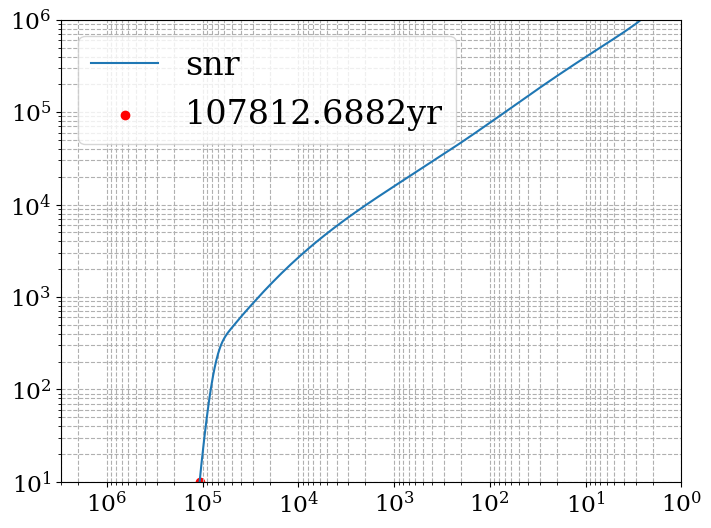

交点坐标: t = 107812.688220, snr = 10.000000


In [ ]:
snr_filled = np.nan_to_num(snr, nan=0)
f1 = interp1d(t_event-t_values, snr_filled, kind='cubic', fill_value="extrapolate")
f2 = interp1d(t_event-t_values, np.full(len(snr),10), kind='cubic', fill_value="extrapolate")

def func_diff(x_val):
    return f1(x_val) - f2(x_val)

initial_guess = 10**3


x_intersect = fsolve(func_diff, initial_guess)[0]
y_intersect = f1(x_intersect)


plt.figure(figsize=(8, 6))
plt.plot(t_event-t_values, snr, label="snr")
plt.scatter([x_intersect], [y_intersect], color='red', label=f"{x_intersect:.4f}yr")

plt.xscale('log')
plt.yscale('log')
plt.xlim( 3 * 10**(6), 10**(0))
plt.ylim(10**(1),10**6)
# plt.xlabel("1-e (log scale)")
# plt.ylabel("a (log scale)")
plt.legend()
plt.grid(True, which="both", ls="--")
plt.show()

print(f"交点坐标: t = {x_intersect:.6f}, snr = {y_intersect:.6f}")

In [ ]:
snr_ = pd.DataFrame({
        't_merge':t_event-t_values,

        'snr':snr
})

snr_.to_csv('data/snr_10_df_2_1200.csv',index=False)

In [217]:
t = t_event - x_intersect
a_band, e_band = query_a_e_at_time(t)
print(f"a_band = {a_band}pc,e_band = {e_band},t = {t} ")

a_band = 0.0014296763528895936pc,e_band = 0.99788874227005,t = 188282.14286507893 


## a_thr calculation

In [218]:
n_max = 100
hc_array = np.zeros((len(e_values), n_max))


def compute_hc_row(i, n_max, m_c, f_orb_values, e_values, dist):
    hc_row = np.zeros(n_max)
    for n in range(1, n_max + 1):
        hc_row[n - 1] = strain.h_c_n(m_c=m_c, f_orb=f_orb_values[i], ecc=e_values[i], n=n, dist=dist).flatten()
    return i, hc_row

results = Parallel(n_jobs=-1)(
    delayed(compute_hc_row)(i, n_max, m_c, f_orb_values, e_values, dist) 
    for i in range(0, len(e_values))
)


for i, hc_row in results:
    hc_array[i] = hc_row


candidate_indices = []

for i in range(len(hc_array)):
    max_hc_n = np.argmax(hc_array[i]) + 1
    max_hc_value = np.max(hc_array[i])
    
    if max_hc_n == 2:
        candidate_indices.append(i)

if candidate_indices:
    min_i = min(candidate_indices)
    print(f"满足条件的最小 i 为 {min_i}, 对应的偏心率 e = {e_values[min_i]}")
else:
    print("没有找到满足条件的 i 值")

# 查询 a_thr 和 e_thr
a_thr, e_thr = query_a_e_at_time(t_values[min_i])

print(f"a_thr = {a_thr}pc,e_thr = {e_thr} ,t = {t_values[min_i]}")

满足条件的最小 i 为 456, 对应的偏心率 e = 0.348678916089257
a_thr = 3.2101808613664422e-06pc,e_thr = 0.348678916089257 ,t = 295885.8310850359


## a_min calculation

In [ ]:
time_vals = np.linspace(0, t_event, 1000000)  # 时间点
a_vals = []
e_vals = []

for tt in time_vals:
    a, e = query_a_e_at_time(tt)  # 获取 (a, e) 对
    a_vals.append(a)
    e_vals.append(e)


e_interp = interp1d(a_vals, e_vals, kind='linear', fill_value="extrapolate")
a_interp = interp1d(e_vals, a_vals, kind='linear', fill_value="extrapolate")

e_at_given_a = e_interp(8*10**(-7))
a_e02 = a_interp(0.2)

## source number calculation

In [221]:
dt1 = t
dt2 = t_values[min_i]-t
dt3 = t_event - t_values[min_i]
print(f"在band之前度过的时间 = {dt1},进入band后轨道圆化之前度过的时间 = {dt2},圆化后到并合度过的时间 = {dt3}")

在band之前度过的时间 = 188282.14286507893,进入band后轨道圆化之前度过的时间 = 107603.688219957,圆化后到并合度过的时间 = 209.0


In [ ]:
N = 2e4
R_h = 1*u.pc
lam_0 = np.log(m_2/m_1) / 13
N_0 = N / 12000
R_0 = R_h / (1*u.pc)
m_1_0 = m_1/ (10*u.Msun)
C = 1
W = 0.27

a_thr1 = a_e02 * u.pc
a_min1 = 2*10**(-7) * u.pc
a_band1 = a_band * u.pc
a_cri1 = a_i
t_band = (t_event - t)  * u.yr
gamm = 1.92*10**(-6) * (u.yr)**(-1) * N_0 * lam_0 * R_0**(-2) * m_1_0**2 *(0.16 * N_0**(-1/2) * lam_0**(-1/2) * R_0**(1/2) * m_1_0**(1/2) * W**(-5/4) *(np.log(9138 * N_0**(-1) * lam_0**(-1) * R_0 * m_1_0 * W**(-5/2)) - 2) - 4 * 10**(-2) * R_0**(1/2)  * (np.log(618 * R_0) - 2 ))


0.010302723595337104 2.0979821700918766 3.586185479157557 1.9555072120880054e-05 1 / yr


In [ ]:
print(f"e_band={e_band},e_thr ={e_thr},e_min = {0.2}")

e_band=0.99788874227005,e_thr =0.348678916089257,e_min = 0.048609641460336986,n2 = 2.0979821700918766,n1 = 0.010302723595337104


In [224]:
def da_dt_inverse(a):

    e = e_interp(a)
    s = da_dt(a*u.pc,e).to(u.pc/u.yr)
    return 1/s.value

In [225]:
# 定义单个子区间的积分任务
def compute_segment(func, lower, upper):
    return quad(func, lower, upper)
 
# 定义分段积分函数（并行化）
def parallel_segmented_integral(func, lower, upper, num_segments, n_jobs=-1):
    # 分割区间
    segment_points = np.linspace(lower, upper, num_segments + 1)
    segment_intervals = list(zip(segment_points[:-1], segment_points[1:]))  # 所有子区间

    # 并行计算所有子区间的积分
    results = Parallel(n_jobs=n_jobs)(
        delayed(compute_segment)(func, seg_lower, seg_upper)
        for seg_lower, seg_upper in segment_intervals
    )

    # 累加所有子区间的积分结果
    total_result = sum(result for result, _ in results)
    total_error = sum(error for _, error in results)

    return total_result, total_error

In [226]:
def number(a1, a2, a3, a4, num_segments=20):
    # 定义积分区间
    intervals = [
        (a4, a2),  # factor = integral from a4 to a2
        (a4, a3),  # n1 = integral from a4 to a3
        (a3, a2),  # n2 = integral from a3 to a2
        (a2, a1),  # n3 = integral from a2 to a1
    ]


    results = [
        parallel_segmented_integral(da_dt_inverse, lower, upper, num_segments)
        for lower, upper in intervals
    ]

    # 提取积分结果
    factor,err = results[0]  # factor = integral from a4 to a2
    n1, err1 = results[1]   # n1 = integral from a4 to a3
    n2, err2 = results[2]   # n2 = integral from a3 to a2
    n3, err3 = results[3]   # n3 = integral from a2 to a1
    k = gamm * t_band / factor
    n1 *= k
    n2 *= k
    n3 *= k

    # 打印结果
    print(n1, n2, n3, k, err1, err2, err3, err)
    arr = [n1, n2, n3]

    return arr

In [227]:
arr = number(0.01, a_band, a_thr, a_e02)
print(arr)

0.003165251529693044 2.1051196498965132 3.6834539663729133 -1.9562670053032234e-05 5.561717598746464e-07 0.002727719106892599 0.00130229831788308 0.0024568361725971154
[<Quantity 0.00316525>, <Quantity 2.10511965>, <Quantity 3.68345397>]


In [228]:
arr

[<Quantity 0.00316525>, <Quantity 2.10511965>, <Quantity 3.68345397>]